In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
soft = torch.nn.Softmax(dim = 1)

In [4]:
txt = list('AbAcAd'*50)

In [6]:
txt[-1:]

['d']

In [7]:
train_df = pd.DataFrame({'x':txt[:-1], 'y':txt[1:]})
train_df[:5]

,x,y
0,A,b
1,b,A
2,A,c
3,c,A
4,A,d


In [9]:
x= torch.tensor(train_df['x'].map({'A':0,'b':1,'c':2,'d':3}))
y= torch.tensor(train_df['y'].map({'A':0,'b':1,'c':2,'d':3}))

### 망한구현 1

In [11]:
#일반적인 풀이... 임베딩 공간 2차원
net = torch.nn.Sequential(
    torch.nn.Embedding(4,2),
    torch.nn.Tanh(),
    torch.nn.Linear(2,4)
)

ebdd,tanh,linr = net #언패킹..
ebdd.weight.data = ebdd.weight.data*0 +0.1 #가중치들 모두 0.1로 변경.
linr.weight.data = linr.weight.data*0 +0.1
linr.bias.data = linr.bias.data*0 +0.1

optimizr = torch.optim.Adam(net.parameters(),lr=0.1)
loss_fn = torch.nn.CrossEntropyLoss()

In [12]:
for epoc in range(200):
  ##1
  netout = net(x)
  ##2
  loss = loss_fn(netout,y)
  ##3
  loss.backward()
  ##4
  optimizr.step()
  optimizr.zero_grad()

In [42]:
#시각화 해보기
h = tanh(ebdd(x))
yhat = soft(net(x))
mat = torch.concat([h,yhat],axis=1).data[:10]

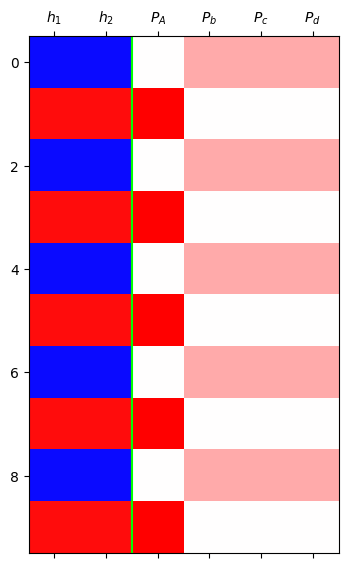

In [44]:
plt.matshow(mat,cmap = 'bwr',vmin = -1, vmax= 1)
plt.axvline(1.5, color = 'lime')
plt.xticks(ticks=range(6),labels=[r"$h_1$",r"$h_2$",r"$P_A$",r"$P_b$",r"$P_c$",r"$P_d$"]);

### 망한거 구현 2 (원핫 인코딩 + 사용자 정의 네트워크)

In [47]:
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

In [71]:
class Hnet(torch.nn.Module): #원핫 인코딩을 임베딩 스페이스로 넣는 네트워크
  def __init__(self):
    super().__init__()
    self.i2h = torch.nn.Linear(4,2,bias = False) #bias false..
    self.tanh = torch.nn.Tanh()
  def forward(self,X):
    ht = self.tanh(self.i2h(X))

    return ht

hnet = Hnet()
linr = torch.nn.Linear(2,4)
hnet.i2h.weight.data = hnet.i2h.weight.data*0 + 0.1
linr.weight.data = linr.weight.data*0 + 0.1
linr.bias.data = linr.bias.data*0 + 0.1

In [72]:
optimizr = torch.optim.Adam(list(hnet.parameters()) + list(linr.parameters()),lr=0.1)
loss_fn = torch.nn.CrossEntropyLoss()

In [75]:
for epoc in range(200):
  ##1
  ht = hnet(X)
  netout = linr(ht)
  ##2
  loss = loss_fn(netout,y)
  ##3
  loss.backward()
  ##4
  optimizr.step()
  optimizr.zero_grad()

In [78]:
netout

tensor([[-3.8691,  3.6860,  3.6860,  3.6860],
        [ 5.4838, -4.9041, -4.9041, -4.9041],
        [-3.8691,  3.6860,  3.6860,  3.6860],
        ...,
        [-3.8691,  3.6860,  3.6860,  3.6860],
        [ 5.4838, -4.9041, -4.9041, -4.9041],
        [-3.8691,  3.6860,  3.6860,  3.6860]], grad_fn=<AddmmBackward0>)

### 실패한 풀이의 다른 구현 2

In [79]:
X = torch.tensor([[1, 0, 0, 0],
                  [0, 1, 0, 0]]).float()
linr = torch.nn.Linear(4,2)

In [80]:
linr(X)

tensor([[ 0.2456, -0.5157],
        [-0.2389, -0.0026]], grad_fn=<AddmmBackward0>)

In [84]:
X[[0]] , linr(X[[0]]).shape

(tensor([[1., 0., 0., 0.]]), torch.Size([1, 2]))

In [85]:
X[0] , linr(X[0]).shape

(tensor([1., 0., 0., 0.]), torch.Size([2]))

In [93]:
df_train = pd.DataFrame({'x':txt[:-1], 'y':txt[1:]})

x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

In [94]:
class Hnet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.i2h = torch.nn.Linear(4,2,bias=False)
        self.tanh = torch.nn.Tanh()
    def forward(self,X):
        h = self.tanh(self.i2h(X))
        return h
hnet = Hnet()
linr = torch.nn.Linear(2,4)
hnet.i2h.weight.data = hnet.i2h.weight.data*0 + 0.1
linr.weight.data = linr.weight.data*0 + 0.1
linr.bias.data = linr.bias.data*0 + 0.1
# 같은 Hnet..

In [95]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(hnet.parameters()) + list(linr.parameters()), lr = 0.1)
L = len(X)
for epoc in range(300):
  ##1
  loss = 0
  for t in range(L):
    Xt,yt = X[t],y[t]
    ht = hnet(Xt)
    ot = linr(ht)
    loss = loss + loss_fn(ot, yt) #두 번째 반복문이 도는 동안의 Loss를 계속반영하기 위해 더한 것...
  loss = loss/L
  ##3
  loss.backward()
  ##4
  optimizr.step()
  optimizr.zero_grad()

In [96]:
linr(hnet(X))

tensor([[-4.0361,  3.8528,  3.8528,  3.8528],
        [ 5.6013, -5.0210, -5.0210, -5.0210],
        [-4.0361,  3.8528,  3.8528,  3.8528],
        ...,
        [-4.0361,  3.8528,  3.8528,  3.8528],
        [ 5.6013, -5.0210, -5.0210, -5.0210],
        [-4.0361,  3.8528,  3.8528,  3.8528]], grad_fn=<AddmmBackward0>)

#### 임베딩 공간의 해석

In [102]:
h = hnet(X).data #h는 원핫 인코딩의 숙성 버전...
h.shape

torch.Size([299, 2])

In [103]:
h.T.shape

torch.Size([2, 299])

In [104]:
h1,h2 = h.T #h의 행벡터 하나씩 언패킹..

In [105]:
h1[::6], h2[::6] #첫 'A'에 대응되는 h값들..

(tensor([-0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582,
         -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582,
         -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582,
         -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582,
         -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582,
         -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582,
         -0.9582, -0.9582]),
 tensor([-0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582,
         -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582,
         -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582,
         -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582,
         -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582,
         -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582, -0.9582,

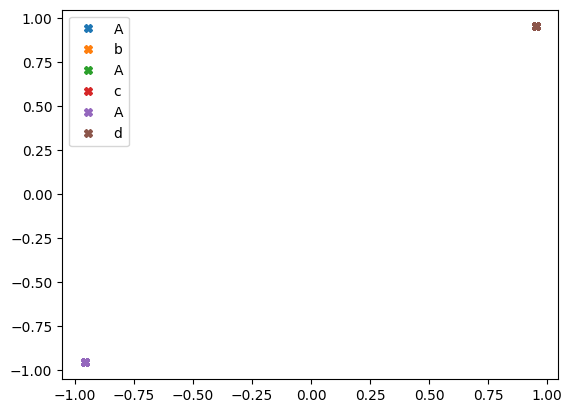

In [108]:
plt.plot(h1[::6],h2[::6],'X',label="A")
plt.plot(h1[1::6],h2[1::6],'X',label="b")
plt.plot(h1[2::6],h2[2::6],'X',label="A")
plt.plot(h1[3::6],h2[3::6],'X',label="c")
plt.plot(h1[4::6],h2[4::6],'X',label="A")
plt.plot(h1[5::6],h2[5::6],'X',label="d")
plt.legend() #각 문자열들을 나타낸 h를 임베딩 공간에서 시각화 한다. 문맥적으로 b,c,d를 동일문자 취급하고 잇다..

##### 임베딩 공간의 해석... : b,c,d를 동일문자 취급한다

## 성공한 구현

### 순환 신경망의 실질적 코드
```python
class rNNCell(torch.nn.Module):
    def __init__(self):
        super().__init__()
        linr1 = torch.nn.Linear(?,?)
        linr2 = torch.nn.Linear(?,?)
        tanh = torch.nn.Tanh()
    def forward(self,Xt,ht):
        ht = tanh(lrnr1(Xt)+lrnr2(ht))
        return ht

init ht
rnncell = rNNCell()

for t in 1:L
    Xt, yt = X[t], y[t]
    ht = rnncell(Xt, ht)
    ot = linr(ht)
    loss = loss + loss_fn(ot, yt)
```

### 성공한 구현 1 `rNNCell`

In [130]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

In [131]:
class rNNCell(torch.nn.Module): #간장을 숙성하는 네트워크
  def __init__(self):
    super().__init__()
    self.i2h = torch.nn.Linear(4,2)
    self.h2h = torch.nn.Linear(2,2) #h를 h로 보내는 변환.. 이미 만들어진 간장을 끌어와서 쓰는 것..
    self.tanh = torch.nn.Tanh()
  def forward(self,Xt,ht): #간장 만들땐 y 필요 없음...
    ht = self.tanh(self.i2h(Xt) + self.h2h(ht))

    return ht



torch.manual_seed(43052)
rnncell = rNNCell() #간장을 숙성하는 네트워크 ...? 왜 괄호 안했지?
cook = torch.nn.Linear(2,4) #간장계란밥을 만드는 네트워크

loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnncell.parameters()) +list(cook.parameters()),lr=0.1)

In [132]:
L = len(X)
for epoc in range(200):
  ht = torch.zeros(2) #(1,2) 가 되어야 하지만 (2,) 도 봐준다. 초기 간장:맹물
  loss = 0
  for t in range(L):
    Xt, yt = X[t],y[t]
    ht = rnncell(Xt,ht)
    ot = cook(ht)
    loss = loss + loss_fn(ot,yt)
  loss = loss/L
  ##3
  loss.backward()
  ##4
  optimizr.step()
  optimizr.zero_grad()

In [135]:
#결과 확인물을 만드는 코드도 상당히 귀찮다..
h = torch.zeros(L,2)
water = torch.zeros(2)
h[0] = rnncell(X[0],water) #올해 콩물 + 작년 간장..(초기값의 간장은 맹물)
for t in range(1,L): #초기엔 이미 한번 위에서 만들었음 두번째부터 반복하면 됨
  h[t] = rnncell(X[t],h[t-1])

yhat = soft(cook(h))
yhat

tensor([[4.1972e-03, 9.4557e-01, 1.9538e-06, 5.0232e-02],
        [9.9994e-01, 5.5549e-05, 8.4703e-10, 1.3137e-06],
        [2.1333e-07, 1.1343e-06, 9.7020e-01, 2.9803e-02],
        ...,
        [2.1324e-07, 1.1337e-06, 9.7020e-01, 2.9796e-02],
        [9.9901e-01, 9.6503e-04, 6.9241e-09, 2.1926e-05],
        [7.2741e-04, 2.5408e-02, 3.3111e-02, 9.4075e-01]],
       grad_fn=<SoftmaxBackward0>)

In [139]:
yhat.data.numpy().round(2)[:10]

array([[0.  , 0.95, 0.  , 0.05],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.97, 0.03],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.03, 0.03, 0.94],
       [0.98, 0.02, 0.  , 0.  ],
       [0.  , 0.97, 0.  , 0.03],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.97, 0.03],
       [1.  , 0.  , 0.  , 0.  ]], dtype=float32)

#### 성공결과 구현

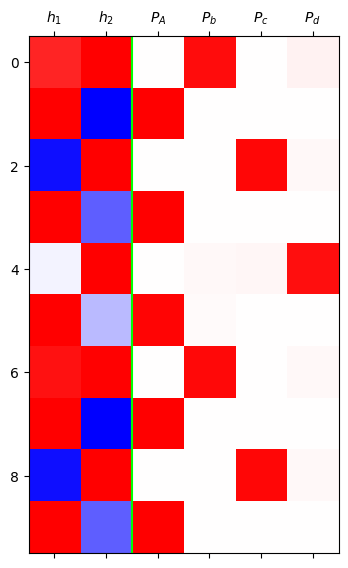

In [146]:
mat = torch.concat([h,yhat],axis=1).data[:10]
plt.matshow(mat,cmap = 'bwr',vmin =-1, vmax = 1)
plt.axvline(1.5,color = 'lime')
plt.xticks(range(6),[r'$h_1$',r'$h_2$',r'$P_A$',r'$P_b$',r'$P_c$',r'$P_d$']);

#### 임베딩 스페이스 시각화

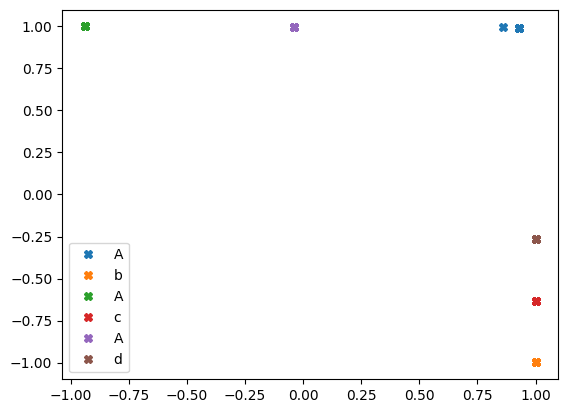

In [147]:
h1,h2 = h.T.data
plt.plot(h1[::6],h2[::6],'X',label="A")
plt.plot(h1[1::6],h2[1::6],'X',label="b")
plt.plot(h1[2::6],h2[2::6],'X',label="A")
plt.plot(h1[3::6],h2[3::6],'X',label="c")
plt.plot(h1[4::6],h2[4::6],'X',label="A")
plt.plot(h1[5::6],h2[5::6],'X',label="d")
plt.legend()

#해석... A끼리는 1만큼 떨어져 있고 소문자들끼리는 약 0.25 씩 떨어져 있다..
#이는 해석하자면 A끼리는 1만큼씩 문맥적으로 차이가 있고, 소문자들은 그것보다 차이가 좀 더 적다는 것이다..
#상식적으로 A들이 각각 다음에 어떤 소문자가 오는 A인지 명확하게 구분만 된다면
#나머지 소문자들을 자동적으로 맞출 수 있다... 그래서 좀 더 A에 비중을 두고 학습하는 것이 바람직하다.

### 성공한 구현2 `RNNCell` 로 구현하기

In [158]:
x = torch.tensor(df_train.x.map({'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(df_train.y.map({'A':0,'b':1,'c':2,'d':3}))
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

In [159]:
torch.manual_seed(43052)
_rnncell = rNNCell()
cook = torch.nn.Linear(2,4) #rNNCell 학습할 때 썼던 가중치들을 사용하고자..

In [160]:
rnncell = torch.nn.RNNCell(4,2) #우리가 힘들게 만든 Hnet이 이거 하나랑 같음
rnncell.weight_ih.data = _rnncell.i2h.weight.data
rnncell.weight_hh.data = _rnncell.h2h.weight.data #이미 만들어둔 간장으로 간장을 만들겠다~~
rnncell.bias_ih.data = _rnncell.i2h.bias.data
rnncell.bias_hh.data = _rnncell.h2h.bias.data

In [161]:
loss = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnncell.parameters()) + list(cook.parameters()),lr = 0.1)

In [162]:
L = len(X)

for epoc in range(200):
  ht = torch.zeros(2) #첫 간장은 맹물~
  loss = 0
  for t in range(L):
    Xt, yt = X[t],y[t]
    ht = rnncell(Xt,ht)
    ot = cook(ht)
    loss = loss + loss_fn(ot,yt)
  ##3
  loss.backward()
  ##4
  optimizr.step()
  optimizr.zero_grad()

In [163]:
#결과물 확인 yhat을 만들자..
h = torch.zeros(L,2)
water = torch.zeros(2)
h[0] = rnncell(X[0],water)
for t in range(1,L):
  h[t] = rnncell(X[t],h[t-1])
yhat = soft(cook(h))

In [165]:
yhat.data.numpy().round(2)[:10] #갈수록 예측 성능 좋아짐..

array([[0.  , 0.95, 0.  , 0.05],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.97, 0.03],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.03, 0.03, 0.94],
       [0.98, 0.02, 0.  , 0.  ],
       [0.  , 0.97, 0.  , 0.03],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.97, 0.03],
       [1.  , 0.  , 0.  , 0.  ]], dtype=float32)

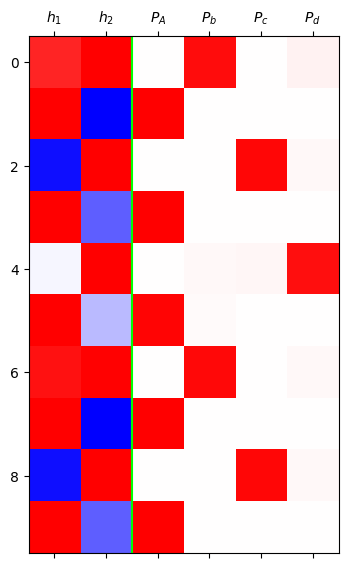

In [169]:
mat = torch.concat([h,yhat],axis =1).data[:10]
plt.matshow(mat, cmap = 'bwr',vmin =-1,vmax= 1)
plt.axvline(1.5,color = 'lime')
plt.xticks(range(6),[r'$h_1$',r'$h_2$',r'$P_A$',r'$P_b$',r'$P_c$',r'$P_d$']);

#### 과제.1 : 'rNNCell'

In [170]:
txt = list('hello'*100)
df_train = pd.DataFrame({'x':txt[:-1], 'y':txt[1:]})
x = torch.tensor(df_train.x.map({'h':0,'e':1,'l':2,'o':3}))
y = torch.tensor(df_train.y.map({'h':0,'e':1,'l':2,'o':3}))
X = torch.nn.functional.one_hot(x).float()
y = torch.nn.functional.one_hot(y).float()

In [173]:
class rNNCell(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.i2h = torch.nn.Linear(4,3)
    self.h2h = torch.nn.Linear(3,3)
    self.tanh = torch.nn.Tanh()
  def forward(self,Xt,ht):
    ht = self.tanh(self.i2h(Xt) + self.h2h(ht)) #exactly 그냥 더하는게 맞음..
    return ht

rnncell = rNNCell()
cook = torch.nn.Linear(3,4)
optimizr = torch.optim.Adam(list(rnncell.parameters()) + list(cook.parameters()),lr = 0.1)

In [174]:
L = len(X)
for epoc in range(200):
  ##1+2
  ht = torch.zeros(3) #초기값.
  loss = 0
  for t in range(L):
    Xt, yt = X[t],y[t]
    ht = rnncell(X[t],ht)
    ot = cook(ht)
    loss = loss + loss_fn(ot,yt)
  loss = loss/L
  ##3
  loss.backward()
  ##4
  optimizr.step()
  optimizr.zero_grad()

In [183]:
h = torch.zeros(L,3)
water = torch.zeros(3)
h[0] = rnncell(X[0],water)

for t in range(1,L):
  h[t] = rnncell(X[t],h[t-1])
yhat = soft(cook(h))

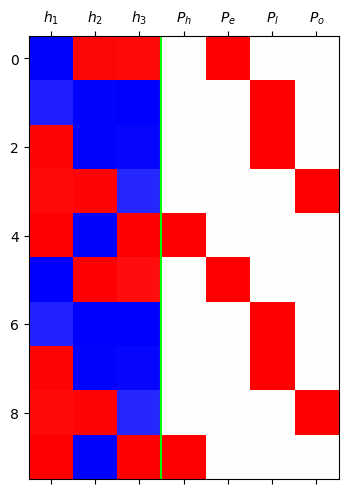

In [186]:
mat = torch.concat([h,yhat],axis = 1).data[:10]
plt.matshow(mat,cmap='bwr',vmin = -1, vmax = 1)
plt.axvline(2.5,color= 'lime')
plt.xticks(range(7),[r'$h_1$',r'$h_2$',r'$h_3$',r'$P_h$',r'$P_e$',r'$P_l$',r'$P_o$']);

#### 과제.2 : 'RNNCell'

In [187]:
rnncell = torch.nn.RNNCell(4,3)
cook = torch.nn.Linear(3,4)

loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnncell.parameters()) + list(cook.parameters()),lr=0.1)

In [188]:
L = len(X)
for epoc in range(200):
  ht = torch.zeros(3)
  loss = 0
  for t in range(L):
    Xt,yt = X[t],y[t]
    ht = rnncell(Xt,ht)
    ot = cook(ht)
    loss = loss + loss_fn(ot,yt)
  loss = loss/L
  ##3
  loss.backward()
  ##4
  optimizr.step()
  optimizr.zero_grad()

In [192]:
h = torch.zeros(L,3)
water = torch.zeros(3)
h[0] = rnncell(X[0],water)
for t in range(1,L):
  h[t] = rnncell(X[t],h[t-1])

yhat = soft(cook(h))

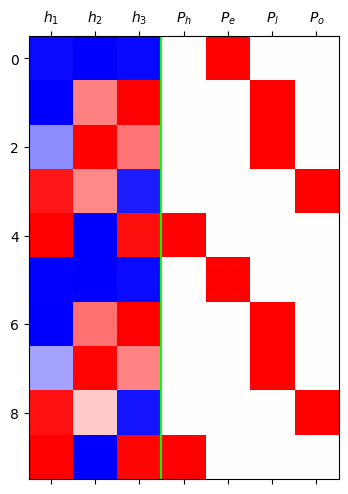

In [193]:
mat = torch.concat([h,yhat],axis = 1).data[:10]
plt.matshow(mat,cmap='bwr',vmin = -1, vmax = 1)
plt.axvline(2.5,color= 'lime')
plt.xticks(range(7),[r'$h_1$',r'$h_2$',r'$h_3$',r'$P_h$',r'$P_e$',r'$P_l$',r'$P_o$']);